In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

import sys
sys.path.append("..")

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import torch
from torch import nn
import torch.nn.functional as F
print(f"Available GPUs: {torch.cuda.device_count()}")

from fastai.layers import ConvLayer, MaxPool
from fastai.basics import Learner, DataLoaders
from fastai.callback.all import *

from Utils.encoders import SkipGramEmbedder
from Utils.model_datasets import SAEDataset
from Utils.train import SAETrainer, ConvSAETrainer, dense_sae_splitter, conv_sae_splitter, set_seed
from Utils.model_utils import DenseSAE, ConvolutionalSAE, LossLogger

from sklearn.model_selection import train_test_split
import random
import numpy as np
import pandas as pd

Available GPUs: 2


## Prot2Vec SAE train

Pretrain a dense and conv SAE using the pretrained skipgram embedder. 

1. Load small interactions csv 
1. Transform w/ embedder 
1. Turn into dataset, put into loader, use trainer object to pretrain saes

In [2]:
# SKIPGRAMPATH = '/home/robertlink/Thesis_work/Chapter_3/SeqEmbedders/GensimWord2Vec/Prot2Vec_current.model'
# dense_embedder = SkipGramEmbedder(SKIPGRAMPATH, reduce = True, outsize = 110-2)
# conv_embedder  = SkipGramEmbedder(SKIPGRAMPATH, reduce = False, outsize = 110-2)

In [3]:
from os import path
from Bio import SeqIO


def embbed_seqs_from_file(embedder, embedded_file_path : str, load_preembedded : bool,
                          seq_path : str or None = None,  
                          alphabet : list or None = None, 
                          max_seq_len : int or None = None):
    """
    
    """
    
    if load_preembedded and path.exists(embedded_file_path):
        return torch.load(embedded_file_path)
    
    assert seq_path and excluded_alphabet and max_seq_len, \
    "If embedding sequences, need to specify sequence file path, embedded file path, excluded_alphabet, and max seq length"
    
    with open(seq_path) as handle:
        
        only_contains = lambda seq, alphabet: set(seq.upper()).issubset(set(alphabet))
        
        seqs = set([str(record.seq) for record in SeqIO.parse(handle, 'fasta') 
                    if only_contain(excluded_alphabet, str(record.seq)) and max_seq_len >= len(record.seq) >= 3])
         
        print("generating encoded matrix...")
        embedded_seqs = embedder(seqs)
        print("saving encoded matrix...")
        torch.save(embedded_seqs, embedded_file_path)
        
        return embedded_seqs

In [3]:
CONV_LOAD  = True
DENSE_LOAD = True

SWISS_DENSE_PATH  = "../Data/EncodedData/Dense_encoded_swiss_current.pt"
SWISS_CONV_PATH   = "../Data/EncodedData/Conv_encoded_swiss_current.pt"

PROT_SEQ_PATH = '/home/robertlink/Thesis_work/Chapter_3/Data/uniprot_sprot.fasta'
ALPHABET      = ('A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V')
MAX_SEQ_LEN   = 110

dense_embedded = embbed_seqs_from_file(dense_embedder, embedded_file_path = SWISS_DENSE_PATH, load_preembedded = DENSE_LOAD,
                                       seq_path = PROT_SEQ_PATH,  
                                       alphabet = ALPHABET, 
                                       max_seq_len = MAX_SEQ_LEN)
    
conv_embedded = embbed_seqs_from_file(conv_embedder, embedded_file_path = SWISS_CONV_PATH, load_preembedded = CONV_LOAD,
                                      seq_path = PROT_SEQ_PATH,  
                                      alphabet = ALPHABET, 
                                      max_seq_len = MAX_SEQ_LEN)

NameError: name 'dense_embedder' is not defined

In [4]:
dense_embedded = torch.load("../Data/EncodedData/reduced_ProtBERT_encoded_110_swissprot.pt")

In [5]:
# # set(uniprot)

# from os import path

# CONV_LOAD         = True
# DENSE_LOAD        = True
# GENERATE_MATRICES = False
# OVERWRITE         = False

# SWISS_DENSE_PATH  = "../Data/EncodedData/Dense_encoded_swiss_current.pt"
# SWISS_CONV_PATH   = "../Data/EncodedData/Conv_encoded_swiss_current.pt"

# does_not_contain = lambda exclusion,seq: not set(exclusion).intersection(list(seq))

# if DENSE_LOAD:
#     x = torch.load(SWISS_DENSE_PATH)
    
# if CONV_LOAD:
#     y = torch.load(SWISS_CONV_PATH)
    
# if GENERATE_MATRICES:
#     from Bio import SeqIO
    
#     with open('/home/robertlink/Thesis_work/Chapter_3/Data/uniprot_sprot.fasta') as handle:
#         swiss = [str(record.seq) for record in SeqIO.parse(handle, 'fasta') 
#                  if does_not_contain(['U','X',"O","B",'Z'], str(record.seq)) and 110 >= len(record.seq) >= 3]
    
#     swiss = set(swiss)
    
#     if not path.exists(SWISS_DENSE_PATH) or OVERWRITE:
#         print("generating dense encoded matrix...")
#         x = dense_embedder(swiss)
#         torch.save(x, SWISS_DENSE_PATH)
    
#     if not path.exists(SWISS_CONV_PATH) or OVERWRITE:
#         print("generatic conv encoded matrix...")
#         y = conv_embedder(swiss)
#         torch.save(y, SWISS_CONV_PATH)

In [6]:
x = eval('nn.ReLU()')
x

ReLU()

In [10]:
set_seed(255)
sae = DenseSAE(1024,
               hidden_layers = [800,600,400],
               dropout = 0.3,
               activation = None,
               train_step = 1).cuda()

In [11]:
trainer = SAETrainer(10, 255, plot = False)

In [12]:
BATCHSIZE = 32

In [13]:
np.array(dense_embedded)

array([[-0.03010186, -0.04915739,  0.02743092, ..., -0.04276931,
        -0.01680565,  0.03357317],
       [-0.01343166, -0.02365689,  0.01948241, ..., -0.0038888 ,
        -0.0024319 ,  0.0323361 ],
       [-0.01600628, -0.04398703,  0.03157784, ..., -0.04963683,
         0.00311908,  0.00247157],
       ...,
       [-0.00486556, -0.00458626,  0.01255652, ..., -0.03191832,
        -0.00221797, -0.01402757],
       [ 0.02968511,  0.0031201 ,  0.03238616, ..., -0.02117445,
        -0.06941934,  0.02499315],
       [-0.04139251, -0.00922378, -0.00467802, ..., -0.01097449,
         0.00827636, -0.00098266]], dtype=float32)

In [14]:
train, val = train_test_split(np.array(dense_embedded), random_state = 255)

train = SAEDataset(torch.tensor(train))
val   = SAEDataset(torch.tensor(val))

loaders = DataLoaders.from_dsets(train, val,
                                 bs=BATCHSIZE,
                                 device="cuda:0")

In [15]:
dense_learner = trainer.train_sae(loaders, sae, dense_sae_splitter)

KeyboardInterrupt: 

In [125]:
train_loss, val_loss = zip(*dense_learner.recorder.values)
min(val_loss)

0.0016862665070220828

In [10]:
set_seed(255)
conv_sae = ConvolutionalSAE(100, 108, 
                            conv_channel_sizes = [200, 100, 50], 
                            pooling_sizes = 2,
                            train_step = 1).cuda(1)

In [11]:
BATCHSIZE = 32

conv_trainer = ConvSAETrainer(1000, 255)

train, val = train_test_split(conv_embedded, random_state = 255)

train = SAEDataset(train)
val   = SAEDataset(val)

loaders = DataLoaders.from_dsets(train, val,
                                 bs = BATCHSIZE,
                                 device="cuda:1")

epoch,train_loss,valid_loss,time
0,3.722505,3.662190,00:12
1,3.497153,3.431549,00:11
2,3.337103,3.283257,00:12
3,3.268028,3.201414,00:12
4,3.191652,3.154119,00:12
5,3.126992,3.099623,00:12
6,3.108463,3.065165,00:12
7,3.102152,3.037443,00:12
8,3.061675,3.031271,00:12
9,3.032909,2.987046,00:12


No improvement since epoch 29: early stopping


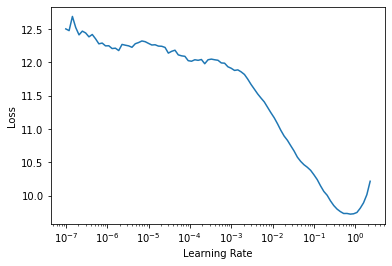

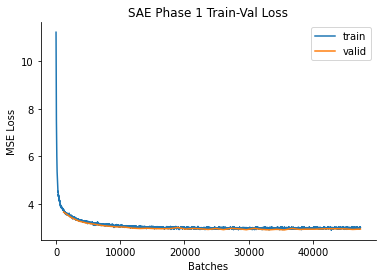

epoch,train_loss,valid_loss,time
0,7.008337,6.908606,00:13
1,6.596988,6.601607,00:13
2,6.449063,6.508685,00:13
3,6.450084,6.524631,00:14
4,6.368833,6.422879,00:14
5,6.354186,6.395910,00:13
6,6.368641,6.367036,00:13
7,6.342368,6.365426,00:13
8,6.343235,6.343744,00:13
9,6.292346,6.418010,00:13


No improvement since epoch 27: early stopping


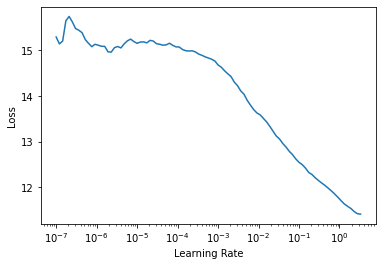

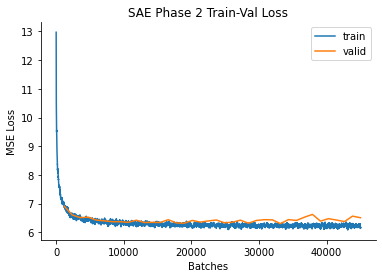

epoch,train_loss,valid_loss,time
0,10.425436,10.393068,00:15
1,10.312373,10.356899,00:15
2,10.408957,10.343164,00:15
3,10.453400,10.335011,00:15
4,10.332556,10.341885,00:15
5,10.210072,10.337702,00:15
6,10.437517,10.331843,00:15
7,10.415085,10.322908,00:15
8,10.326406,10.322172,00:15
9,10.340311,10.311502,00:15


No improvement since epoch 173: early stopping


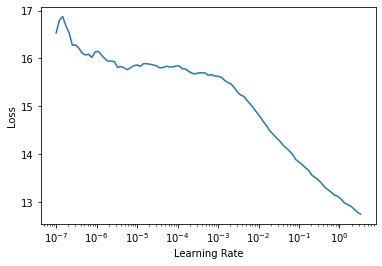

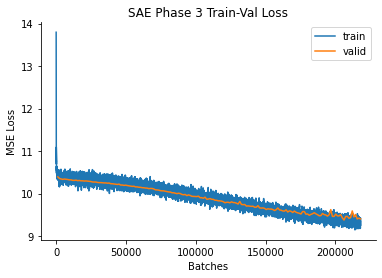

In [12]:
conv_learner = conv_trainer.train_sae(loaders, conv_sae, conv_sae_splitter,
                                      learner_cbs = [EarlyStoppingCallback(patience = 10)])

In [61]:
dense_prot_sae = deepcopy(dense_learner.model)
conv_prot_sae  = deepcopy(conv_learner.model)

torch.save(dense_prot_sae, "../SeqEmbedders/SAEs/Dense_SwissProt_SAE.pt")
torch.save(conv_prot_sae, "../SeqEmbedders/SAEs/Conv_SwissProt_SAE.pt")

In [21]:
# ### Encoder
# conv1 = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# # Now 28x28x32
# maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same')
# # Now 14x14x32
# conv2 = tf.layers.conv2d(inputs=maxpool1, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# # Now 14x14x32
# maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same')
# # Now 7x7x32
# conv3 = tf.layers.conv2d(inputs=maxpool2, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# # Now 7x7x16
# encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same')
# # Now 4x4x16

### Decoder
# upsample1 = tf.image.resize_images(encoded, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# # Now 7x7x16
# conv4 = tf.layers.conv2d(inputs=upsample1, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# # Now 7x7x16
# upsample2 = tf.image.resize_images(conv4, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# # Now 14x14x16
# conv5 = tf.layers.conv2d(inputs=upsample2, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# # Now 14x14x32
# upsample3 = tf.image.resize_images(conv5, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# # Now 28x28x32
# conv6 = tf.layers.conv2d(inputs=upsample3, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# # Now 28x28x32

# logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3,3), padding='same', activation=None)
# #Now 28x28x1

## Pass logits through sigmoid to get reconstructed image
# decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
# loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# # Get cost and define the optimizer
# cost = tf.reduce_mean(loss)
# opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Refine Prot2Vec SAEs on RNAInter data

In [4]:
small_interactions = pd.read_csv("/home/robertlink/Thesis_work/Chapter_3/Data/TrainingData/PositiveSamples/RNAInter_small_interactions_current.csv")
del small_interactions["Unnamed: 0"]
small_interactions

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas
0,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGCATCGGTACCATGATAACCGAAAAAGGACA
1,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTGGAAAATAGAAAAGTCTCGCTCTCTGCCCCTCAGCCTAACTTCCTTTAT
2,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAATTTAGTAAATAAAACTACTTAA
3,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA
4,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12156,RP33979079,rno-miR-374-5p,MIMAT0003208,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGISYGRKKRRQRRRAHQNSQTHQASLSKQPTSQPRGDPTGPKE,P04608,AUAUAAUACAACCUGCUAAGUG
12157,RP33979091,hsa-miR-203b-5p,MIMAT0019813,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9526,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAEPDRAHYNIVTFCCKCDSTLRLCVQSTHVDIRTLEDLLMGTLGIVCPICSQKP,P03129,UAGUGGUCCUAAACAUUUCACA
12158,RP33979092,hsa-miR-203b-3p,MIMAT0019814,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9526,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAEPDRAHYNIVTFCCKCDSTLRLCVQSTHVDIRTLEDLLMGTLGIVCPICSQKP,P03129,UUGAACUGUUAAGAACCACUGGA
12159,RP33979111,hiv1-miR-TAR-5p,MIMAT0006016,miRNA,Human immunodeficiency virus 1,tat,155871.0,protein,Human immunodeficiency virus 1,0.9975,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGISYGRKKRRQRRRAHQNSQTHQASLSKQPTSQPRGDPTGPKE,P04608,UCUCUCUGGUUAGACCAGAUCUGA


In [48]:
rnainter_dense_embedded = dense_embedder(small_interactions['proteins'])
rnainter_conv_embedded  = conv_embedder(small_interactions['proteins'])

In [55]:
from copy import deepcopy

def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True

dense_learner.model.train_step = 1
conv_learner.model.train_step  = 1

dense_prot_sae = deepcopy(dense_learner.model)
conv_prot_sae  = deepcopy(conv_learner.model)

torch.save(dense_prot_sae, "../SeqEmbedders/SAEs/Dense_SwissProt_SAE.pt")
torch.save(conv_prot_sae, "../SeqEmbedders/SAEs/Conv_SwissProt_SAE.pt")

unfreeze_all_layers(dense_prot_sae)
unfreeze_all_layers(conv_prot_sae)

In [56]:
train, val = train_test_split(rnainter_dense_embedded, random_state = 255)

train = SAEDataset(train)
val   = SAEDataset(val)

loaders = DataLoaders.from_dsets(train, val,
                                 bs=BATCHSIZE,
                                 device="cuda:1")

epoch,train_loss,valid_loss,time
0,0.540421,0.487178,00:04
1,0.515014,0.486025,00:04
2,0.539396,0.488536,00:04
3,0.532108,0.483145,00:04
4,0.527229,0.482777,00:04
5,0.522305,0.481570,00:04
6,0.523785,0.483031,00:04
7,0.545947,0.491695,00:04
8,0.541823,0.488749,00:04
9,0.540369,0.485059,00:04


No improvement since epoch 12: early stopping


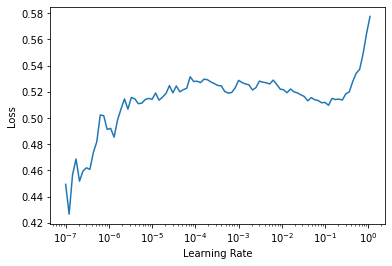

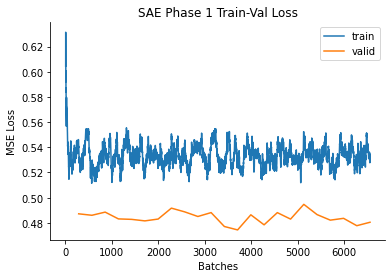

epoch,train_loss,valid_loss,time
0,0.542667,0.497301,00:04
1,0.518654,0.490800,00:04
2,0.526044,0.494888,00:04
3,0.526637,0.495390,00:04
4,0.520313,0.481103,00:04
5,0.534921,0.493270,00:04
6,0.539786,0.491883,00:04
7,0.526140,0.482002,00:04
8,0.529591,0.486734,00:04
9,0.520216,0.488184,00:04


No improvement since epoch 38: early stopping


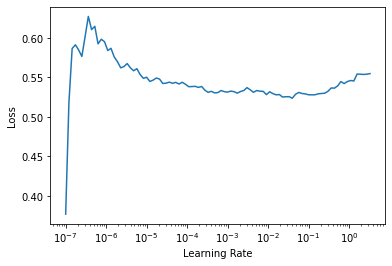

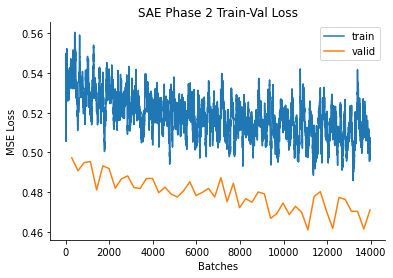

epoch,train_loss,valid_loss,time
0,0.561260,0.507014,00:04
1,0.563218,0.503123,00:04
2,0.554397,0.502249,00:04
3,0.559375,0.496095,00:04
4,0.556129,0.489941,00:04
5,0.562618,0.500089,00:04
6,0.545927,0.490436,00:04
7,0.557767,0.494328,00:04
8,0.556991,0.497347,00:04
9,0.550531,0.507424,00:04


No improvement since epoch 4: early stopping


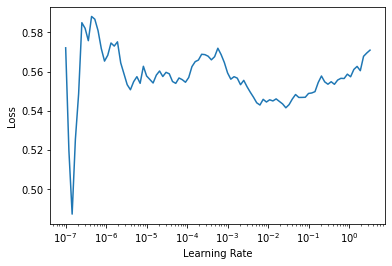

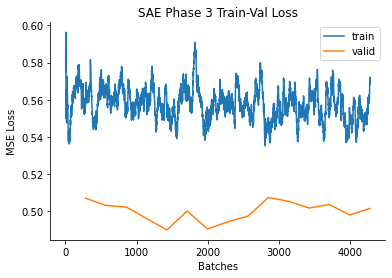

epoch,train_loss,valid_loss,time
0,0.619037,0.550670,00:04
1,0.620097,0.556950,00:04
2,0.623358,0.564179,00:04
3,0.632130,0.556446,00:04
4,0.636131,0.571903,00:04
5,0.626593,0.561410,00:04
6,0.613377,0.558561,00:04
7,0.636246,0.553681,00:04
8,0.608474,0.549536,00:04
9,0.628782,0.560764,00:04


No improvement since epoch 12: early stopping


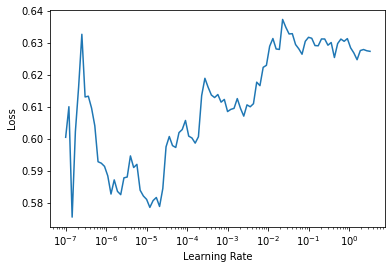

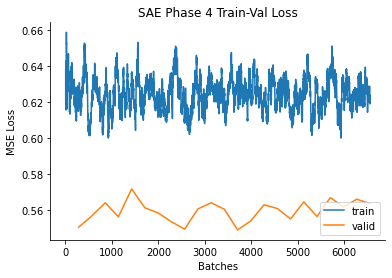

In [57]:
small_dense_learner = trainer.train_sae(loaders, dense_prot_sae, dense_sae_splitter,
                                        learner_cbs = [EarlyStoppingCallback(patience = 10)])

In [58]:
train, val = train_test_split(rnainter_conv_embedded, random_state = 255)

train = SAEDataset(train)
val   = SAEDataset(val)

loaders = DataLoaders.from_dsets(train, val,
                                 bs=BATCHSIZE,
                                 device="cuda:1")

epoch,train_loss,valid_loss,time
0,3.167973,3.152719,00:04
1,3.174107,3.143786,00:04
2,3.145881,3.129816,00:04
3,3.149739,3.124547,00:04
4,3.146597,3.115901,00:04
5,3.138080,3.104200,00:04
6,3.131649,3.099593,00:04
7,3.094615,3.089009,00:04
8,3.113120,3.088258,00:04
9,3.085174,3.080144,00:04


No improvement since epoch 282: early stopping


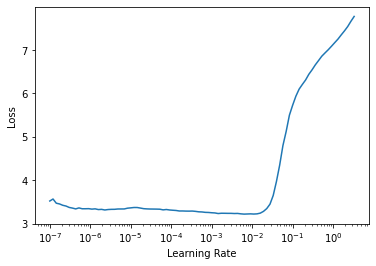

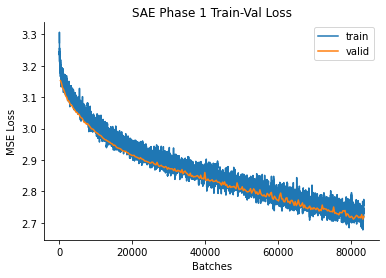

epoch,train_loss,valid_loss,time
0,6.684603,6.670012,00:04
1,6.569023,6.525426,00:04
2,6.475654,6.428522,00:04
3,6.435197,6.358861,00:04
4,6.343188,6.303128,00:04
5,6.304834,6.259238,00:04
6,6.177167,6.226035,00:04
7,6.232924,6.194195,00:05
8,6.196147,6.167088,00:04
9,6.125487,6.145153,00:04


No improvement since epoch 79: early stopping


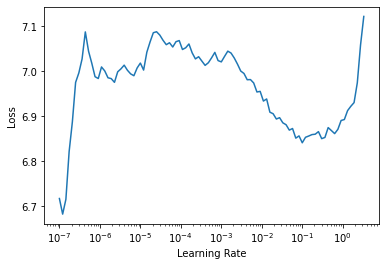

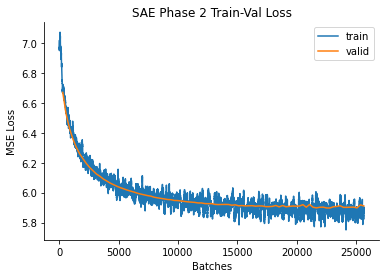

epoch,train_loss,valid_loss,time
0,9.825166,9.723531,00:05
1,9.504531,9.519499,00:05
2,9.410666,9.438811,00:05
3,9.274264,9.397241,00:05
4,9.381446,9.376842,00:05
5,9.401911,9.350582,00:05
6,9.346884,9.340911,00:05
7,9.381944,9.332762,00:05
8,9.237905,9.312261,00:05
9,9.352918,9.325007,00:05


No improvement since epoch 15: early stopping


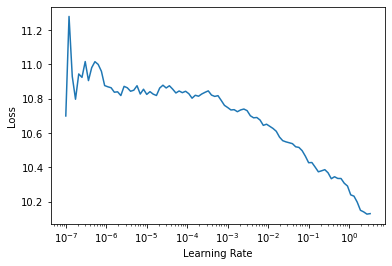

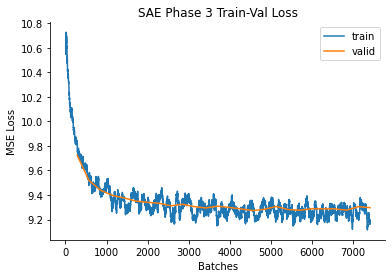

In [59]:
small_conv_learner = conv_trainer.train_sae(loaders, conv_prot_sae, conv_sae_splitter,
                                             learner_cbs = [EarlyStoppingCallback(patience = 10)])

In [60]:
small_dense_prot_sae = deepcopy(small_dense_learner.model)
small_conv_prot_sae  = deepcopy(small_conv_learner.model)

torch.save(small_dense_prot_sae, "../SeqEmbedders/SAEs/Dense_RNAInter_refined_SAE.pt")
torch.save(small_conv_prot_sae, "../SeqEmbedders/SAEs/Conv_RNAInter_refined_SAE.pt")

# RNA2Vec SAE training

In [13]:
SKIPGRAMPATH = '/home/robertlink/Thesis_work/Chapter_3/SeqEmbedders/GensimWord2Vec/RNA2Vec_current.model'
dense_embedder = SkipGramEmbedder(SKIPGRAMPATH, reduce = True, outsize = 100-2)
conv_embedder  = SkipGramEmbedder(SKIPGRAMPATH, reduce = False, outsize = 100-2)

In [ ]:
CONV_LOAD  = True
DENSE_LOAD = True

EMBEDDED_DENSE_PATH = "../Data/EncodedData/Dense_encoded_RNA_current.pt"
EMBEDDED_CONV_PATH  = "../Data/EncodedData/Conv_encoded_RNA_current.pt"

RNA_SEQ_PATH = ""
ALPHABET     = ('A','U','C','G')
MAX_SEQ_LEN  = 100

dense_embedded = embbed_seqs(dense_embedder, embedded_file_path = EMBEDDED_DENSE_PATH, load_preembedded = DENSE_LOAD,
                             seq_path = RNA_SEQ_PATH,  
                             alphabet = ALPHABET, 
                             max_seq_len = MAX_SEQ_LEN)
    
conv_embedded = embbed_seqs(conv_embedder, embedded_file_path = EMBEDDED_CONV_PATH, load_preembedded = CONV_LOAD,
                            seq_path = RNA_SEQ_PATH,  
                            alphabet = ALPHABET, 
                            max_seq_len = MAX_SEQ_LEN)

In [5]:
# set(uniprot)

from os import path

CONV_LOAD         = True
DENSE_LOAD        = True
GENERATE_MATRICES = False
OVERWRITE         = False

SWISS_DENSE_PATH  = "../Data/EncodedData/Dense_encoded_rna_current.pt"
SWISS_CONV_PATH   = "../Data/EncodedData/Conv_encoded_rna_current.pt"

does_not_contain = lambda exclusion,seq: not set(exclusion).intersection(list(seq))

if DENSE_LOAD:
    x = torch.load(SWISS_DENSE_PATH)
    
if CONV_LOAD:
    y = torch.load(SWISS_CONV_PATH)
    
if GENERATE_MATRICES:
    from Bio import SeqIO
    
    with open('/home/robertlink/Thesis_work/Chapter_3/Data/uniprot_sprot.fasta') as handle:
        swiss = [str(record.seq) for record in SeqIO.parse(handle, 'fasta') 
                 if does_not_contain(['U','X',"O","B",'Z'], str(record.seq)) and 110 >= len(record.seq) >= 3]
    
    swiss = set(swiss)
    
    if not path.exists(SWISS_DENSE_PATH) or OVERWRITE:
        print("generating dense encoded matrix...")
        x = dense_embedder(swiss)
        torch.save(x, SWISS_DENSE_PATH)
    
    if not path.exists(SWISS_CONV_PATH) or OVERWRITE:
        print("generatic conv encoded matrix...")
        y = conv_embedder(swiss)
        torch.save(y, SWISS_CONV_PATH)

In [6]:
set_seed(255)
sae = DenseSAE(100,
               hidden_layers = [80,60,40,20],
               dropout = 0.2,
               train_step = 1).cuda(1)

In [7]:
trainer = SAETrainer(1000, 255)

In [8]:
BATCHSIZE = 32

In [9]:
train, val = train_test_split(x, random_state = 255)

train = SAEDataset(train)
val   = SAEDataset(val)

loaders = DataLoaders.from_dsets(train, val,
                                 bs=BATCHSIZE,
                                 device="cuda:1")

epoch,train_loss,valid_loss,time
0,0.288475,0.265717,00:11
1,0.260309,0.230057,00:11
2,0.246947,0.217230,00:10
3,0.244074,0.211123,00:10
4,0.237780,0.205412,00:10
5,0.228946,0.203636,00:11
6,0.222332,0.199243,00:10
7,0.226038,0.198579,00:11
8,0.228003,0.197771,00:11
9,0.219765,0.192976,00:11


No improvement since epoch 42: early stopping


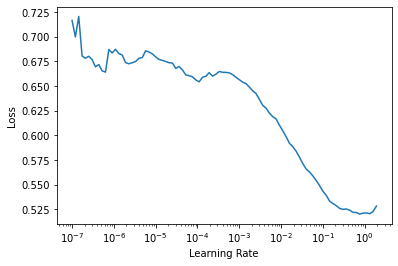

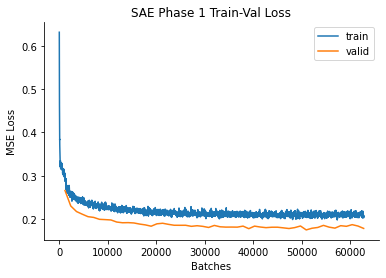

epoch,train_loss,valid_loss,time
0,0.228289,0.191594,00:12
1,0.219656,0.188273,00:12
2,0.217134,0.189519,00:12
3,0.217436,0.184570,00:12
4,0.217536,0.185738,00:12
5,0.220094,0.189380,00:12
6,0.215378,0.184739,00:12
7,0.212888,0.183850,00:12
8,0.216739,0.185595,00:12
9,0.212739,0.184206,00:12


No improvement since epoch 33: early stopping


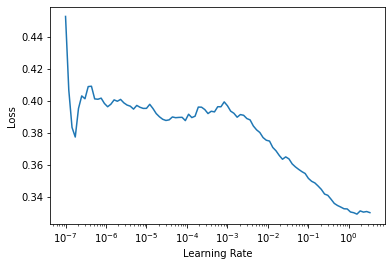

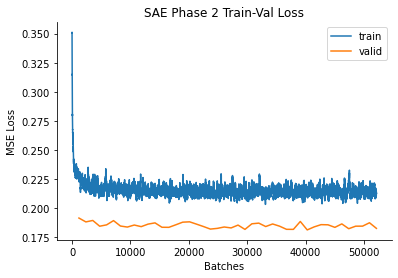

epoch,train_loss,valid_loss,time
0,0.274980,0.216648,00:13
1,0.266050,0.217672,00:13
2,0.262798,0.214226,00:13
3,0.258888,0.207723,00:13
4,0.264928,0.209982,00:13
5,0.258363,0.209787,00:13
6,0.255706,0.210841,00:13
7,0.253978,0.207437,00:13
8,0.254606,0.206922,00:13
9,0.254578,0.206075,00:13


No improvement since epoch 35: early stopping


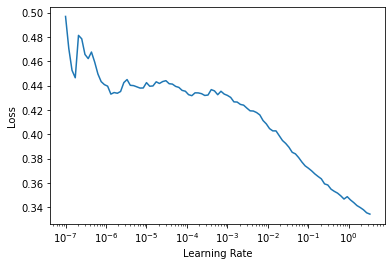

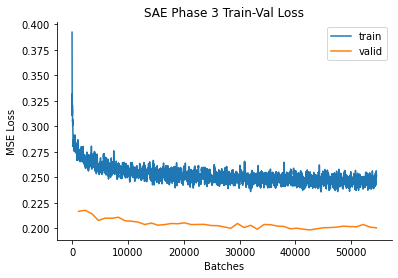

epoch,train_loss,valid_loss,time
0,0.319426,0.243775,00:12
1,0.324315,0.246413,00:12
2,0.308172,0.239414,00:11
3,0.307881,0.240321,00:12
4,0.307388,0.240999,00:12
5,0.305475,0.233098,00:12
6,0.301084,0.239197,00:12
7,0.314175,0.239026,00:12
8,0.309095,0.242028,00:12
9,0.312665,0.237352,00:12


No improvement since epoch 40: early stopping


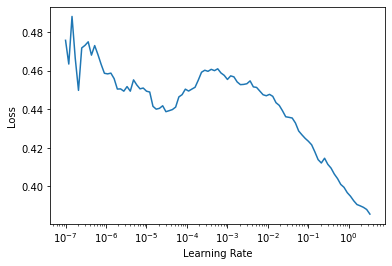

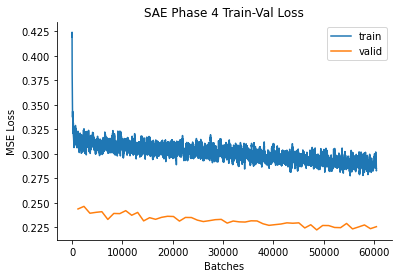

In [10]:
dense_learner = trainer.train_sae(loaders, sae, dense_sae_splitter,
                                  learner_cbs = [EarlyStoppingCallback(patience = 10)])

In [10]:
from Utils.train import ConvSAETrainer, conv_sae_splitter
set_seed(255)
conv_sae = ConvolutionalSAE(100, 108, 
                            conv_channel_sizes = [200, 100, 50], 
                            pooling_sizes = 2,
                            train_step = 1).cuda(1)

In [11]:
BATCHSIZE = 32

conv_trainer = ConvSAETrainer(1000, 255)

train, val = train_test_split(y, random_state = 255)

train = SAEDataset(train)
val   = SAEDataset(val)

loaders = DataLoaders.from_dsets(train, val,
                                 bs = BATCHSIZE,
                                 device="cuda:1")

epoch,train_loss,valid_loss,time
0,3.722505,3.662190,00:12
1,3.497153,3.431549,00:11
2,3.337103,3.283257,00:12
3,3.268028,3.201414,00:12
4,3.191652,3.154119,00:12
5,3.126992,3.099623,00:12
6,3.108463,3.065165,00:12
7,3.102152,3.037443,00:12
8,3.061675,3.031271,00:12
9,3.032909,2.987046,00:12


No improvement since epoch 29: early stopping


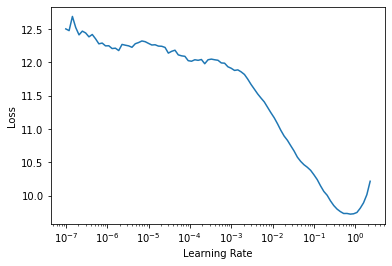

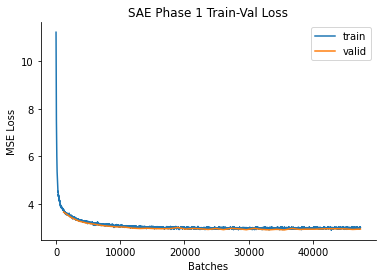

epoch,train_loss,valid_loss,time
0,7.008337,6.908606,00:13
1,6.596988,6.601607,00:13
2,6.449063,6.508685,00:13
3,6.450084,6.524631,00:14
4,6.368833,6.422879,00:14
5,6.354186,6.395910,00:13
6,6.368641,6.367036,00:13
7,6.342368,6.365426,00:13
8,6.343235,6.343744,00:13
9,6.292346,6.418010,00:13


No improvement since epoch 27: early stopping


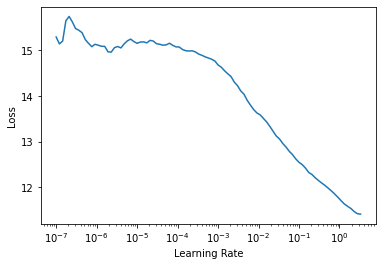

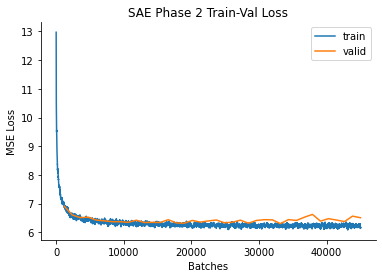

epoch,train_loss,valid_loss,time
0,10.425436,10.393068,00:15
1,10.312373,10.356899,00:15
2,10.408957,10.343164,00:15
3,10.453400,10.335011,00:15
4,10.332556,10.341885,00:15
5,10.210072,10.337702,00:15
6,10.437517,10.331843,00:15
7,10.415085,10.322908,00:15
8,10.326406,10.322172,00:15
9,10.340311,10.311502,00:15


In [ ]:
conv_learner = conv_trainer.train_sae(loaders, conv_sae, conv_sae_splitter,
                                      learner_cbs = [EarlyStoppingCallback(patience = 10)])

# BERT SAE Embedding for Negative Sampling

In [15]:
import torch
from transformers import AutoTokenizer, AutoModel, pipeline
import re
import numpy as np
import os
import requests
from tqdm.auto import tqdm

from torch.utils.data import IterableDataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn; sbn.set_style('ticks')
import matplotlib.gridspec as gridspec
import numpy as np

from torch import nn

# Parse files
import pandas as pd

from Bio import SeqIO

from itertools import combinations
from tqdm.notebook import tqdm

import sentencepiece

## Initialize ProtBERT

In [3]:
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

In [4]:
model = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")

In [5]:
does_not_contain = lambda exclusion,seq: not set(exclusion).intersection(list(seq))

with open('/home/robertlink/Thesis_work/Chapter_3/Data/uniprot_sprot.fasta') as handle:
    swiss = [str(record.seq) for record in SeqIO.parse(handle, 'fasta') 
             if does_not_contain(['U','X',"O","B",'Z'], str(record.seq)) and 110 >= len(record.seq) >= 3]

swiss = set(swiss)

In [6]:
processed_swiss = list(pd.Series(list(swiss)).str.join(' '))

tokenized_proteins = tokenizer(processed_swiss,
                               padding        = 'max_length',
                               max_length     = 110 + 2,
                               return_tensors ='pt')

tokenized_proteins

{'input_ids': tensor([[ 2, 21, 12,  ...,  0,  0,  0],
        [ 2, 21, 12,  ...,  0,  0,  0],
        [ 2,  7,  7,  ...,  0,  0,  0],
        ...,
        [ 2, 21, 19,  ...,  0,  0,  0],
        [ 2, 21, 12,  ...,  0,  0,  0],
        [ 2, 21, 12,  ...,  0,  0,  0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [7]:
#tokenized_proteins.to('cuda');
#model.to('cuda');

In [8]:
class TestData(IterableDataset):
    """
    START CHANGING THIS SHITTTTT, THIS I THE WAY TO GOOOOO
    """
    def __init__(self, proteins, tokenizer, model, chunksize, cuda = True):
        self.protein_combos  = proteins
        self.tokenizer       = tokenizer
        self.model           = model
        self.chunksize       = chunksize
        
        self.cuda = cuda
        
        if self.cuda:
            self.model.to('cuda');
        
    def __iter__(self):
        # swap below as a protein comboooooooo
        
        for i in tqdm(range(0,len(self.protein_combos),self.chunksize)):
            
            tokenized_protein = self.tokenizer(list(self.protein_combos[i:i+self.chunksize]),
                                               padding = 'max_length',
                                               max_length = 112,
                                               return_tensors='pt')
            
            if self.cuda:
                tokenized_protein.to('cuda');
            
            yield mean_pooling(self.model(**tokenized_protein), tokenized_protein['attention_mask']).detach()

In [9]:
import torch

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [10]:
# ~20 minutes total, but doesn't lead to power cap issues nor OOM crashes
BERT_TRANSFORMED_UNIQUE_SEQS_PATH = '../Data/SwissProt_Bert_Encoded.pt'
CHUNKSIZE = 2

if os.path.exists(BERT_TRANSFORMED_UNIQUE_SEQS_PATH):
    x_tensor = torch.load(BERT_TRANSFORMED_UNIQUE_SEQS_PATH)
else:
    x_data   = TestData(processed_swiss, tokenizer, model, CHUNKSIZE, cuda = True)
    x_tensor = torch.stack([i for i in x_data])
    
    SHAPE = len(x_tensor) * CHUNKSIZE
    x_tensor = x_tensor.reshape(SHAPE, 1024)
    torch.save(x_tensor, BERT_TRANSFORMED_UNIQUE_SEQS_PATH)

In [11]:
x_tensor = x_tensor.cpu()

In [2]:
from cuml import UMAP, DBSCAN

ModuleNotFoundError: No module named 'cuml'

In [25]:
test = eval('[1,23,3]')
test

[1, 23, 3]

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train, val = train_test_split(x_tensor, random_state = 255)

train = SAEDataset(train)
val   = SAEDataset(val)

loaders = DataLoaders.from_dsets(train, val,
                                 bs=BATCHSIZE,
                                 device="cuda:0")

In [19]:
from fastai.layers import LinBnDrop

set_seed(255)

sae = DenseSAE(1024,
               hidden_layers = [800, 600, 400, 200],
               dropout = 0.2,
               train_step = 1).cuda()

In [20]:
from Utils.train_utils import SAETrainer

In [22]:
# Testing default no callbacks arg
trainer = SAETrainer(15, 255)

epoch,train_loss,valid_loss,time
0,0.003387,0.002661,00:04
1,0.003992,0.004139,00:04
2,0.002719,0.002437,00:04
3,0.002303,0.002163,00:04
4,0.002033,0.001950,00:03
5,0.001916,0.001803,00:03
6,0.001749,0.001689,00:04
7,0.001578,0.001429,00:03
8,0.001520,0.001406,00:04
9,0.001416,0.001224,00:04


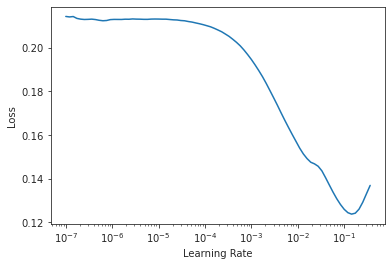

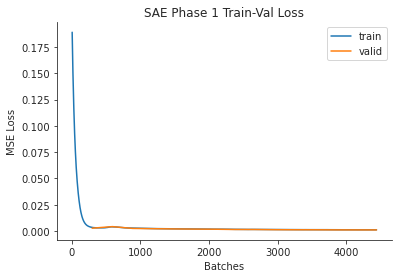

epoch,train_loss,valid_loss,time
0,0.001448,0.001199,00:04
1,0.001442,0.001258,00:04
2,0.001404,0.001219,00:04
3,0.001391,0.001191,00:04
4,0.001368,0.001132,00:04
5,0.001317,0.001214,00:04
6,0.001349,0.001189,00:04
7,0.001249,0.001102,00:04
8,0.001241,0.001065,00:04
9,0.001208,0.001078,00:04


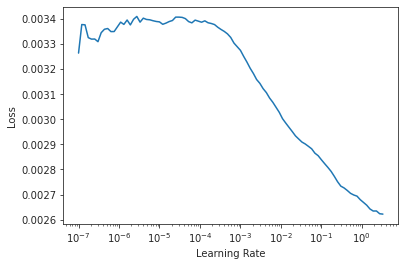

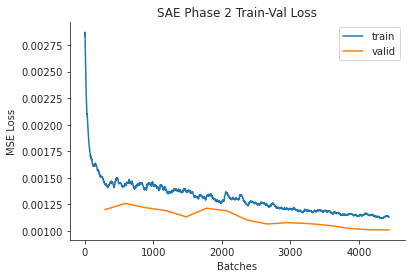

epoch,train_loss,valid_loss,time
0,0.001483,0.001152,00:04
1,0.001340,0.001094,00:04
2,0.001359,0.001086,00:04
3,0.001318,0.001092,00:04
4,0.001292,0.001069,00:04
5,0.001308,0.001077,00:04
6,0.001309,0.001107,00:04
7,0.001272,0.001054,00:04
8,0.001256,0.001075,00:04
9,0.001268,0.001057,00:04


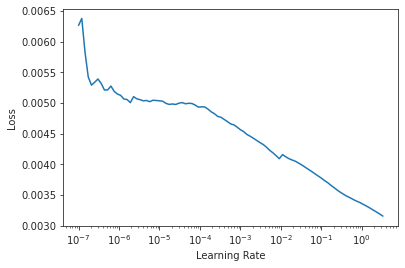

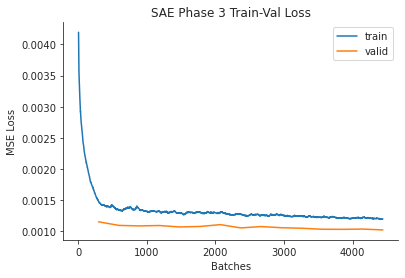

epoch,train_loss,valid_loss,time
0,0.001364,0.001115,00:04
1,0.001326,0.001086,00:04
2,0.001296,0.001103,00:04
3,0.001294,0.001093,00:04
4,0.001295,0.001079,00:04
5,0.001277,0.001084,00:04
6,0.001252,0.001068,00:04
7,0.001251,0.001064,00:04
8,0.001249,0.001062,00:04
9,0.001251,0.001055,00:04


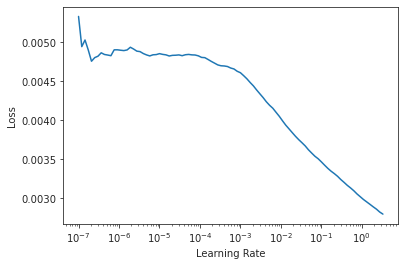

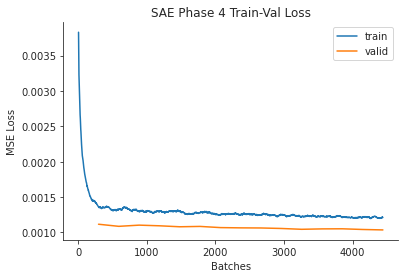

In [23]:
learner = trainer.train_sae(loaders, sae)

In [23]:
train_loss, val_loss = zip(*learner.recorder.values)
min_val_loss = min(val_loss)

min_val_loss

0.0010060821659862995

In [83]:
from fastai.torch_core import trainable_params
from functools import partial

In [44]:
learner = Learner(loaders, sae,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

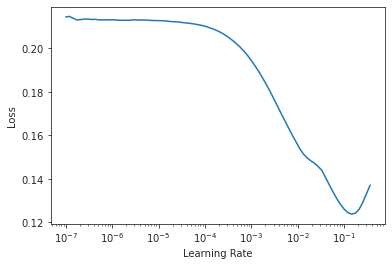

In [45]:
lr_min, lr_steep = learner.lr_find()

In [46]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.003596,0.002607,00:04
1,0.002641,0.002444,00:04
2,0.002472,0.002311,00:04
3,0.002341,0.002211,00:04
4,0.002226,0.002110,00:04
5,0.002145,0.002031,00:04
6,0.002068,0.001930,00:04
7,0.001983,0.001859,00:04
8,0.001915,0.001798,00:04
9,0.001849,0.001728,00:04


No improvement since epoch 77: early stopping


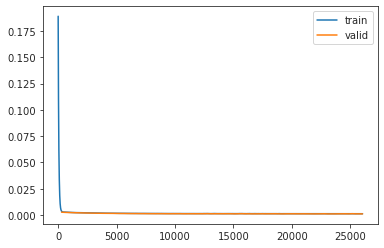

In [57]:
learner.recorder.plot_loss()

In [70]:
train_loss, val_loss = zip(*learner.recorder.values)
min(val_loss)

0.0009729936136864126

In [31]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[0])
freeze_single_layer(learner.model._temp_layers[0])
freeze_single_layer(learner.model.hidden_layers[-1])

In [32]:
learner.model.train_step = 2

learner = Learner(loaders, learner.model,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

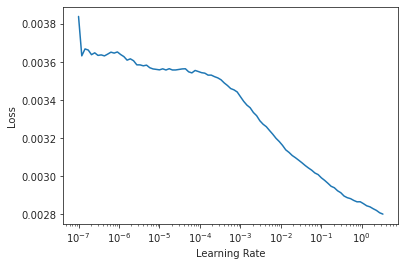

In [33]:
lr_min, lr_steep = learner.lr_find()

In [34]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.001673,0.001376,00:05
1,0.001387,0.001141,00:05
2,0.001329,0.001139,00:05
3,0.001270,0.001067,00:04
4,0.001255,0.001039,00:05
5,0.001235,0.001038,00:04
6,0.001221,0.001012,00:04
7,0.001190,0.001035,00:05
8,0.001195,0.000994,00:05
9,0.001175,0.001023,00:04


No improvement since epoch 18: early stopping


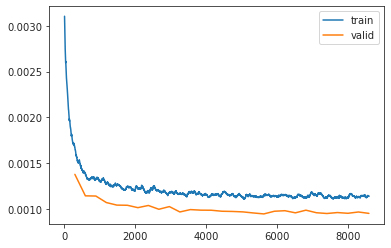

In [35]:
learner.recorder.plot_loss()

In [36]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[1])
freeze_single_layer(learner.model._temp_layers[1])
freeze_single_layer(learner.model.hidden_layers[-2])

In [37]:
learner.model.train_step = 3

learner = Learner(loaders, learner.model,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

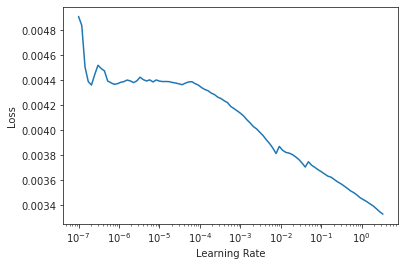

In [38]:
lr_min, lr_steep = learner.lr_find()

In [39]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.001572,0.001257,00:05
1,0.001336,0.001093,00:05
2,0.001301,0.001055,00:05
3,0.001230,0.001033,00:05
4,0.001231,0.001033,00:05
5,0.001218,0.001012,00:05
6,0.001197,0.001023,00:05
7,0.001198,0.001001,00:05
8,0.001206,0.001020,00:05
9,0.001199,0.000999,00:05


No improvement since epoch 20: early stopping


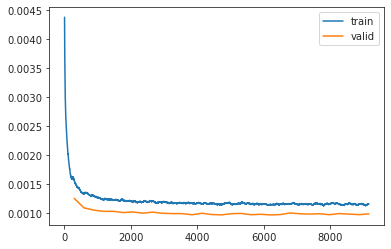

In [40]:
learner.recorder.plot_loss()

In [41]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[2])
freeze_single_layer(learner.model._temp_layers[2])
freeze_single_layer(learner.model.hidden_layers[-3])

In [42]:
learner.model.train_step = 4

learner = Learner(loaders, learner.model,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

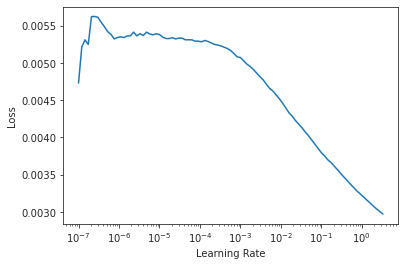

In [43]:
lr_min, lr_steep = learner.lr_find()

In [44]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.001383,0.001117,00:04
1,0.001285,0.001049,00:05
2,0.001239,0.001022,00:04
3,0.001219,0.001008,00:05
4,0.001197,0.001000,00:05
5,0.001200,0.001010,00:05
6,0.001203,0.001000,00:04
7,0.001203,0.000990,00:04
8,0.001181,0.000981,00:05
9,0.001195,0.000997,00:05


No improvement since epoch 8: early stopping


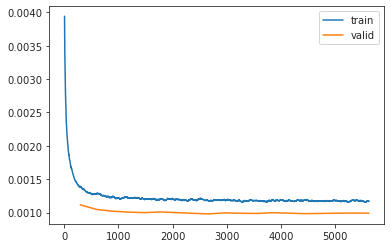

In [45]:
learner.recorder.plot_loss()

In [46]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[3])
freeze_single_layer(learner.model.hidden_layers[-4])

In [47]:
for param in trainable_params(learner.model):
    print(param)

In [48]:
learner.model.train_step = 0
learner.model.eval();

## Apply Unrefined SAE on RNAInter

In [49]:
df = pd.read_csv("../Data/RNAInter_small_interactions_current.csv", index_col = 0)
df

,Interaction_ID,RNA_Name,HGNC/Entrex/Ensembl_ID,RNA_type,Species,Protein_name,NCBI_GeneID,Protein_Type,Also_species,Confidence_score,proteins,UniprotID,rnas
907814,RP00953369,RP11-125K10.5,ENSG00000228165,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CACCATTCTTCAGTTATCACAGTACTGTACCTTTCAGATATACAGCATCGGTACCATGATAACCGAAAAAGGACA
911713,RP00957415,MIR3184,ENSG00000266919,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GCGCGGGTTAGGAAGCAAGACTGAGGGGCCTCAGACCGAGCTTTTGGAAAATAGAAAAGTCTCGCTCTCTGCCCCTCAGCCTAACTTCCTTTAT
912105,RP00957817,AL365205.2,ENSG00000268745,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,CCAATGTTTCATTTCAACTGGCTTAAATCTTCAAAGTGGTTAAGAATTTAGTAAATAAAACTACTTAA
912866,RP00958609,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,HMGN3,9324.0,TF,Homo sapiens,0.5117,MPKRKSPENTEGKDGSKVTKQEPTRRSARLSAKPAPPKPEPKPRKTSAKKEPGAKISRGAKGKKEEKQEAGKEGTAPSENGETKAEEAQKTESVDNEGE,Q15651,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA
2122927,RP02246386,RP11-717A5.2,ENSG00000273196,lncRNA,Homo sapiens,SUMO2,6613.0,TF,Homo sapiens,0.5117,MADEKPKEGVKTENNDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVY,P61956,GATCATATATACTTGCATAATATCATCCCTTCCCTTGATTTCTTTCAATCTAAAAATAAATATGAGAAAAACA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923224,RP33979079,rno-miR-374-5p,MIMAT0003208,miRNA,Rattus norvegicus,tat,155871.0,protein,Human immunodeficiency virus 1,0.9768,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGISYGRKKRRQRRRAHQNSQTHQASLSKQPTSQPRGDPTGPKE,P04608,AUAUAAUACAACCUGCUAAGUG
8923231,RP33979091,hsa-miR-203b-5p,MIMAT0019813,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9526,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAEPDRAHYNIVTFCCKCDSTLRLCVQSTHVDIRTLEDLLMGTLGIVCPICSQKP,P03129,UAGUGGUCCUAAACAUUUCACA
8923232,RP33979092,hsa-miR-203b-3p,MIMAT0019814,miRNA,Homo sapiens,E7,1489079.0,protein,Human papillomavirus type 16,0.9526,MHGDTPTLHEYMLDLQPETTDLYCYEQLNDSSEEEDEIDGPAGQAEPDRAHYNIVTFCCKCDSTLRLCVQSTHVDIRTLEDLLMGTLGIVCPICSQKP,P03129,UUGAACUGUUAAGAACCACUGGA
8923245,RP33979111,hiv1-miR-TAR-5p,MIMAT0006016,miRNA,Human immunodeficiency virus 1,tat,155871.0,protein,Human immunodeficiency virus 1,0.9975,MEPVDPRLEPWKHPGSQPKTACTNCYCKKCCFHCQVCFITKALGISYGRKKRRQRRRAHQNSQTHQASLSKQPTSQPRGDPTGPKE,P04608,UCUCUCUGGUUAGACCAGAUCUGA


In [50]:
from itertools import combinations

protein_combos = combinations(set(df['proteins'].str.join(' ')), r = 2)

x,y = zip(*protein_combos)

In [51]:
class TestData(IterableDataset):
    """
    
    """
    def __init__(self, proteins, tokenizer, model, chunksize, cuda = True):
        self.protein_combos  = proteins
        self.tokenizer       = tokenizer
        self.model           = model
        self.chunksize       = chunksize
        
        self.cuda = cuda
        
        if self.cuda:
            self.model.to('cuda');
        
    def __iter__(self):
        # swap below as a protein comboooooooo
        
        for i in tqdm(range(0,len(self.protein_combos),self.chunksize)):
            
            tokenized_protein = self.tokenizer(list(self.protein_combos[i:i+self.chunksize]),
                                               padding = 'max_length',
                                               max_length = 112,
                                               return_tensors='pt')
            
            if self.cuda:
                tokenized_protein.to('cuda');
            
            yield mean_pooling(self.model(**tokenized_protein), tokenized_protein['attention_mask']).detach()

In [52]:
#tokenized_proteins.to('cuda');
model.to('cuda');

In [53]:
CHUNKSIZE = 2
x_data = TestData(x, tokenizer, model, CHUNKSIZE, cuda = True)
y_data = TestData(y, tokenizer, model, CHUNKSIZE, cuda = True)

In [54]:
# ~40 minutes total, but doesn't lead to power cap issues nor OOM crashes

protein_combo_tensor_x_path = "../Data/Protein_BERT_transformed_combo_tensor_x.pt"
protein_combo_tensor_y_path = "../Data/Protein_BERT_transformed_combo_tensor_y.pt"

from os import path

if not path.exists(protein_combo_tensor_x_path):
    x_tensor          = torch.stack([i for i in x_data])
    SHAPE             = len(x)
    x_tensor_reshaped = x_tensor.reshape(SHAPE, 1024)
    torch.save(x_tensor_reshaped, protein_combo_tensor_x_path)
else:
    x_tensor_reshaped = torch.load(protein_combo_tensor_x_path)

if not path.exists(protein_combo_tensor_y_path):
    y_tensor          = torch.stack([i for i in y_data])
    SHAPE             = len(y)
    y_tensor_reshaped = y_tensor.reshape(SHAPE, 1024)
    torch.save(y_tensor_reshaped, protein_combo_tensor_y_path)
else:
    y_tensor_reshaped = torch.load(protein_combo_tensor_y_path)

In [55]:
diff_matrix = learner.model(x_tensor_reshaped) - learner.model(y_tensor_reshaped)

In [56]:
diff_matrix.shape

torch.Size([53628, 200])

In [57]:
from cuml import UMAP
reduced_difference_matrix = UMAP(random_state=255).fit_transform(diff_matrix.cpu().numpy())

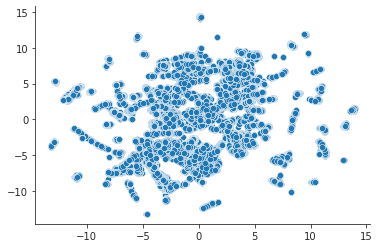

In [60]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.scatterplot(x = reduced_difference_matrix[:,0],
                y = reduced_difference_matrix[:,1])

sbn.despine()

In [61]:
SAVE = True

if SAVE:
    torch.save(learner.model, "../Data/BERT_Swiss_unrefined_SAE.pt")

## Refine ProtBERT SAE on small interaction data

In [62]:
small_prots = set(df['proteins'])
len(small_prots)

328

In [63]:
processed_small_prots = list(pd.Series(list(small_prots)).str.join(' '))

In [64]:
# ~20 minutes total, but doesn't lead to power cap issues nor OOM crashes
BERT_TRANSFORMED_UNIQUE_SEQS_PATH = '../Data/SmallInteraction_Bert_Encoded.pt'
CHUNKSIZE = 2

if os.path.exists(BERT_TRANSFORMED_UNIQUE_SEQS_PATH):
    x_tensor = torch.load(BERT_TRANSFORMED_UNIQUE_SEQS_PATH)
    
else:
    x_data   = TestData(processed_small_prots, tokenizer, model, CHUNKSIZE, cuda = True)
    x_tensor = torch.stack([i for i in x_data])
    
    SHAPE = len(x_tensor) * CHUNKSIZE
    x_tensor = x_tensor.reshape(SHAPE, 1024)
    torch.save(x_tensor, BERT_TRANSFORMED_UNIQUE_SEQS_PATH)

In [65]:
x_tensor = x_tensor.cpu()

In [67]:
BATCHSIZE = 128

In [68]:
train, val = train_test_split(x_tensor, random_state = 255)

train = SAEDataset(train)
val   = SAEDataset(val)

loaders = DataLoaders.from_dsets(train, val,
                                 bs=BATCHSIZE,
                                 device="cuda:0")

In [69]:
from fastai.torch_core import trainable_params
from functools import partial

In [70]:
def unfreeze_all_layers(model):
    for param in model.parameters():
        param.requires_grad = True

In [71]:
unfreeze_all_layers(learner.model)

In [72]:
from copy import deepcopy

learner.model.train_step = 1
small_sae = deepcopy(learner.model)

initial_small_sae_params = deepcopy(small_sae.state_dict())

In [73]:
small_sae.load_state_dict(initial_small_sae_params)

<All keys matched successfully>

In [74]:
small_sae.train_step = 1

In [75]:
set_seed(255)
learner = Learner(loaders, small_sae,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

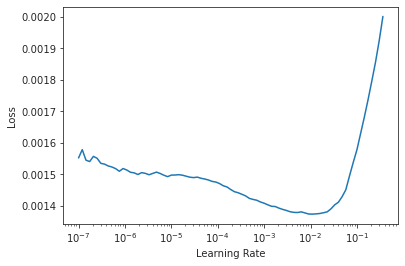

In [76]:
lr_min, lr_steep = learner.lr_find()

In [77]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.001429,0.001775,00:01
1,0.001443,0.001873,00:01
2,0.001417,0.001917,00:01
3,0.001435,0.001942,00:01
4,0.001411,0.001951,00:01
5,0.001404,0.001948,00:01
6,0.001409,0.001945,00:01
7,0.001419,0.001937,00:01
8,0.001414,0.001926,00:01
9,0.001419,0.001917,00:01


No improvement since epoch 0: early stopping


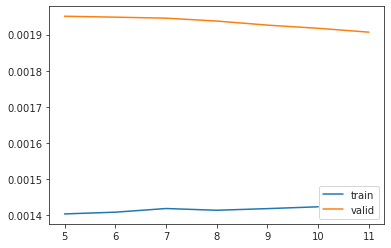

In [78]:
learner.recorder.plot_loss()

In [79]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[0])
freeze_single_layer(learner.model._temp_layers[0])
freeze_single_layer(learner.model.hidden_layers[-1])

In [80]:
learner.model.train_step = 2

learner = Learner(loaders, learner.model,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

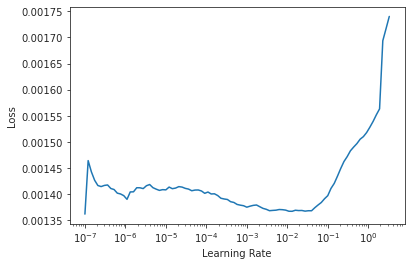

In [81]:
lr_min, lr_steep = learner.lr_find()

In [82]:
lr_min, lr_steep

(0.0013182567432522773, 9.12010818865383e-07)

In [83]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.001414,0.002031,00:01
1,0.001432,0.002017,00:01
2,0.001403,0.001980,00:01
3,0.001398,0.001938,00:01
4,0.001389,0.001902,00:01
5,0.001408,0.001865,00:01
6,0.001407,0.001818,00:01
7,0.001406,0.001780,00:01
8,0.001399,0.001737,00:01
9,0.001442,0.001690,00:01


No improvement since epoch 34: early stopping


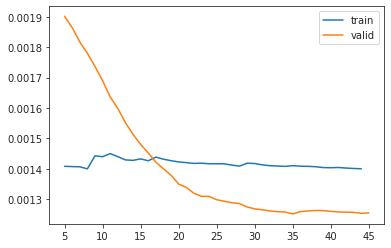

In [84]:
learner.recorder.plot_loss()

In [85]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[1])
freeze_single_layer(learner.model._temp_layers[1])
freeze_single_layer(learner.model.hidden_layers[-2])

In [86]:
learner.model.train_step = 3

learner = Learner(loaders, learner.model,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

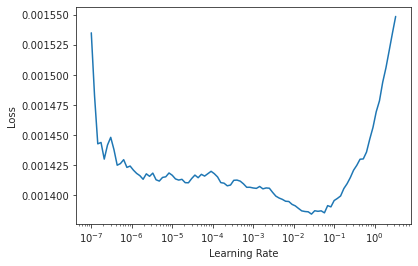

In [87]:
lr_min, lr_steep = learner.lr_find()

In [88]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.001344,0.001541,00:01
1,0.001384,0.001336,00:01
2,0.001393,0.001248,00:01
3,0.001415,0.001208,00:01
4,0.001395,0.001189,00:01
5,0.001403,0.001186,00:01
6,0.001410,0.001190,00:01
7,0.001411,0.001198,00:01
8,0.001400,0.001200,00:01
9,0.001396,0.001206,00:01


No improvement since epoch 5: early stopping


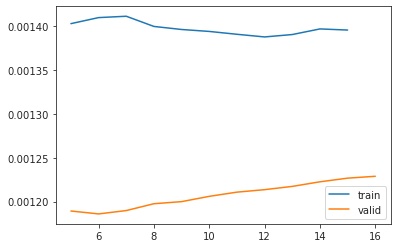

In [89]:
learner.recorder.plot_loss()

In [90]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[2])
freeze_single_layer(learner.model._temp_layers[2])
freeze_single_layer(learner.model.hidden_layers[-3])

In [91]:
learner.model.train_step = 4

learner = Learner(loaders, learner.model,
                  loss_func = nn.MSELoss(),
                  splitter  = dense_splitter,
                  cbs       = [EarlyStoppingCallback(patience = 10)],
                  model_dir = '.'
                  )

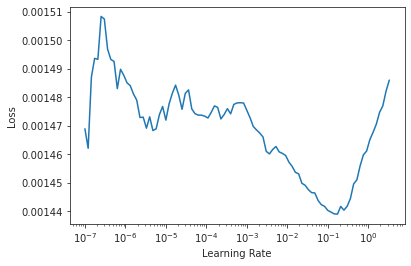

In [92]:
lr_min, lr_steep = learner.lr_find()

In [93]:
lr_min, lr_steep

(0.017378008365631102, 3.630780702224001e-05)

In [94]:
learner.fit_one_cycle(1000, lr_max = slice(lr_steep, lr_min))

epoch,train_loss,valid_loss,time
0,0.001431,0.001257,00:01
1,0.001473,0.001259,00:01
2,0.001442,0.001260,00:01
3,0.001475,0.001265,00:01
4,0.001499,0.001272,00:01
5,0.001482,0.001269,00:01
6,0.001487,0.001273,00:01
7,0.001488,0.001273,00:01
8,0.001477,0.001273,00:01
9,0.001480,0.001277,00:01


No improvement since epoch 0: early stopping


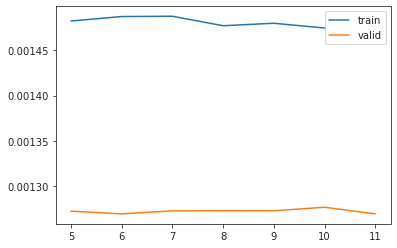

In [95]:
learner.recorder.plot_loss()

In [96]:
def freeze_single_layer(layer):
    for param in layer.parameters():
        param.requires_grad = False
        
freeze_single_layer(learner.model.hidden_layers[3])
freeze_single_layer(learner.model.hidden_layers[-4])

In [97]:
for param in trainable_params(learner.model):
    print(param)

In [98]:
learner.model.train_step = 0
learner.model.eval();

## Apply Embedder for RNAInter Data

In [99]:
diff_matrix = learner.model(x_tensor_reshaped) - learner.model(y_tensor_reshaped)

In [105]:
diff_matrix.shape

torch.Size([53628, 200])

In [100]:
from cuml import UMAP
reduced_difference_matrix = UMAP(random_state=255).fit_transform(diff_matrix.cpu().numpy())

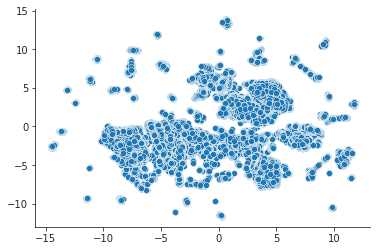

In [103]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.scatterplot(x = reduced_difference_matrix[:,0],
                y = reduced_difference_matrix[:,1])

sbn.despine()

In [104]:
SAVE = True

if SAVE:
    torch.save(learner.model, "../Data/BERT_Swiss_refined_SAE.pt")